## DQN CartPole-v0

Below is the 

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


ModuleNotFoundError: No module named 'PIL'

In [11]:
env = gym.make('CartPole-v0').unwrapped

is_ipython = 'inline' in matplotlib.get_backend()

if is_ipython:
    from IPython import display
    
plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

True


In [75]:
"""
Define a tuple called 'Transition' containing state, action, next state, and reward (s,a,s_next,r)
"""
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

"""
ReplayMemory contains a buffer of previous transitions.
"""
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        # Save transition to ReplayMemory
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        # Randomly sample batch_size worth of transitions
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [76]:
"""
Represent Q function via a neural network.

States correspond to image patches, and actions correspond to apply force to move
the cart either left or right. 

"""
class DQN(nn.Module):
    
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # The number of input connections is dependent on the output of conv2d layers
        # The resulting output is given by:
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size-1) - 1) // stride + 1
        
        convwidth = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convheight = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convwidth * convheight * 32
        
        self.head = nn.Linear(linear_input_size, outputs)
        
    def forward(self, x):
        """
        Feed x (either single state or batch of states) into network. 
        Returns a tensor with 2*size_of_batch, one per each action.
        """
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [77]:
"""
Utility functions for extracting and preprocessing rendered images from the environment. 
"""

resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    # Return middle of cart
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

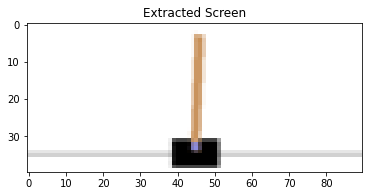

In [78]:
# Test utility methods
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(), 
          interpolation='none')

plt.title('Extracted Screen')
plt.show()

# Training Network

In [79]:
# Training hyperparameters

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size to initalize layers.
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Number of actions for env
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# mean squared backprop.
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10_000)

In [80]:

steps_done = 0

def select_action(state):
    # Select action using eps greedy to choose action.
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1)
        
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

In [81]:
#  A helper function for plotting the durations of episdoes anlong with an average over the last 100 episdoes.
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Epsidoe')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        
    # Pause to update figures.
    plt.pause(0.001) 
    
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [91]:
"""
The following function preforms a single optimization step by sampling a batch, concatenating
it into a single tensor, and computes the Q and value fuctions for the state, adding them to the loss.
We use a target network to also compute the value function of s_next for stability. This network's parameters
are kept frozen, only updated occasionally.
"""

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    
    # transpose the batch converting it from a batch-array of Transitions to Transition of batch-array.
    batch = Transition(*zip(*transitions))
    
    # Compute mask of non-terminal state and concatenate the batch elements.
    non_terminal_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    
    non_terminal_next_states = torch.cat([s_next for s_next in batch.next_state if s_next is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s,a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # Compute V(s_next) using target network
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_terminal_mask] = target_net(non_terminal_next_states).max(1)[0].detach()
    
    # Compute expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute (Huber) loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Apply back prop
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    

In [92]:
"""
The main training loop. 
"""

'\nThe main training loop. \n'

In [93]:
num_eps = 100

for i_ep in range(num_eps):
    
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Take action, get reward. 
        action = select_action(state)
        _, r, done, _ = env.step(action.item())
        reward = torch.tensor([r], device=device)
        
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        # Store transition in memory.
        memory.push(state, action, next_state, reward)
        
        # Move to next state.
        state = next_state
        
        # Preform optimization step.
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update target network using policy network
    if i_ep % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
print("Done")
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Done


<Figure size 432x288 with 0 Axes>

In [97]:
# Save model
path = './DQN_example.pth'
torch.save(policy_net.state_dict(), path)

In [98]:
policy_net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 3.1361e-01, -5.6625e-01,  2.6738e-01,  6.3557e-02, -2.7364e-01],
                        [-5.4401e-01, -5.4036e-01,  4.6905e-01,  4.8551e-02, -2.2646e-01],
                        [ 6.5749e-02,  1.2504e-01, -3.7587e-02, -3.1990e-01, -2.2491e-01],
                        [ 5.6515e-03,  3.5408e-01, -1.2476e+00, -2.5062e-01, -8.6933e-02],
                        [ 2.3484e-01, -3.6962e-01, -1.0988e+00, -7.6707e-01,  5.5542e-01]],
              
                       [[ 3.0812e-01, -5.4403e-01,  3.8564e-01,  4.9684e-01, -1.9297e-01],
                        [-6.7304e-01, -1.9338e-01,  4.4777e-01,  6.7477e-01, -1.5149e-01],
                        [ 6.5107e-02,  6.0230e-03,  1.5608e-01,  4.6063e-01, -2.4941e-01],
                        [ 1.4258e-01,  3.1615e-01, -9.2600e-01,  7.2977e-01,  3.6589e-03],
                        [ 5.0355e-05, -2.4284e-01, -4.7299e-01, -5.7449e-02, -9.1366e-02]],
              
                       [[ 2.